# An "Affine" Mathematical Model for Wealth Inequality
In an article[[1]](https://www.scientificamerican.com/article/is-inequality-inevitable/) published in Scientific American (which is itself based on these papers[[2]](https://arxiv.org/abs/1511.00770)[[3]](https://arxiv.org/abs/1604.02370)), a model is presented that parametrizes wealth inequality based on a simple "garage sale" exchange model. This Jupyter notebook contains my attempt to reproduce and build upon the results presented in the aforementioned article.

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
from scipy import stats
from random import randint, gammavariate
from tqdm.notebook import tqdm
from multiprocessing import Pool

In [2]:
class Analysis:
    def __init__(self, N_epochs=2500, N_checkpoints=0, N_actors=1000, 
                 starting_wealth=1000, transaction_size=0.1):
        # Seeding parameters
        self.N_actors = N_actors
        self.starting_wealth = starting_wealth
        self.transaction_size = transaction_size
        self.N_epochs = N_epochs
        self.N_checkpoints = N_checkpoints
        # Steady-state tracking information
        self.gini_coefficients = []
        # Bank
        self.reset_bank()
        # Seed RNG
        np.random.seed(int(time.time()))
        
    def reset_bank(self, show_init_dist=True):
        """Reset bank information"""
        self.bank = np.ones(self.N_actors)*self.starting_wealth
        self.sorted_bank = None
        self.sorted_actors = None
        self.total_wealth = np.sum(self.bank)
        if show_init_dist:
            # Show that wealth is initially evenly distributed
            self.plot_wealth_dist()
            plt.title("Initial Wealth Distribution")
            plt.ylim(0, self.starting_wealth+100)
            
        return
    
    def update_bank(self, transactions, cur_epoch):
        """Update bank information"""
        self.bank += transactions
        if self.N_checkpoints > 0:
            epoch_step = int(1.0*self.N_epochs/self.N_checkpoints)
            if cur_epoch%epoch_step == 0 or self.N_epochs <= self.N_checkpoints:
                self.sorted_bank = np.sort(self.bank)[::-1]
                self.sorted_actors = np.argsort(self.bank)[::-1]
                self.total_wealth = np.sum(self.bank)
                gini = self.plot_lorenz_curve(no_plot=True, N_points=10000)
                self.gini_coefficients.append(gini)
        elif cur_epoch == self.N_epochs-1:
            self.sorted_bank = np.sort(self.bank)[::-1]
            self.sorted_actors = np.argsort(self.bank)[::-1]
            self.total_wealth = np.sum(self.bank)
        return
    
    def plot_wealth_dist(self, show_oligarch=False):
        """Plot a basic wealth distribution"""
        plt.scatter(range(self.N_actors), self.bank, s=10);
        if show_oligarch:
            plt.scatter(self.bank.argmax(), self.bank.max(), marker="*", 
                        s=50, label="Oligarch")
        plt.xlabel("Actor");
        plt.ylabel("Wealth");
        plt.title("Wealth Distribution");
        plt.axhline(np.average(self.bank), color="r", label="Average Wealth");
        plt.legend();

        to_print = float(np.sum(self.bank > np.average(self.bank))/self.N_actors*100)
        print("{:0.2f}% of actors have more wealth than average.".format(to_print))
        return
        
    def plot_wealth_ineq(self, N_points=50):
        """p% of actors vs. w% of total wealth held by P% of actors"""
        vals = []
        percentages = np.linspace(0, 1, N_points)
        for p in percentages:
            # Wealth held by p% of actors
            wealth_held = np.sum(self.sorted_bank[:int(self.N_actors*p)])
            vals.append(wealth_held/self.total_wealth)

        # Wealth inequality plot
        plt.scatter(percentages, vals, s=10);
        plt.xlabel("% of Actors");
        plt.ylabel("% of Total Wealth Held");
        plt.title("Basic Wealth Inequality Plot");
        return
    
    def gini_coeff(self, x, y):
        """Calculate Gini coefficient using trapezoidal integral approximation"""
        return (np.trapz(x,y)-0.5)/0.5
    
    def plot_lorenz_curve(self, N_points=500, no_plot=False):
        """Fraction of wealth held by actors with wealth < w vs. fraction of actors that
           hold wealth < w, where w is some percentage of the total wealth
        """
        # Calculate values for Lorenz curve
        cumulative_wealth = []
        cumulative_actors = []
        for p in np.linspace(0, 1, N_points):
            actors_with_lt_w = self.sorted_bank < self.total_wealth*p
            # Fraction of wealth held by actors with wealth < w
            cumulative_wealth.append(
                np.sum(self.sorted_bank[actors_with_lt_w])/self.total_wealth
            )
            # Fraction of actors that hold wealth < w
            cumulative_actors.append(np.sum(actors_with_lt_w)/self.N_actors)
        # Cast to numpy arrays
        cumulative_wealth = np.array(cumulative_wealth)
        cumulative_actors = np.array(cumulative_actors)     
        # Calculate Gini coefficient
        gini = self.gini_coeff(cumulative_actors, cumulative_wealth)
        if no_plot:
            return gini
        else:
            # Set up plot
            fig = plt.figure(figsize=(5,5))
            axes = plt.subplot(111)
            axes.set_aspect(1.0)
            # Fill plot
            plt.scatter(cumulative_actors, cumulative_wealth, s=10);
            plt.xlabel("Cumulative Population");
            plt.ylabel("Cumulative Wealth");
            plt.title("Lorenz Curve (Gini = {:.3f})".format(gini));
            return
        
    def plot_gini_evolution(self):
        """Plot Gini coefficients stored during run of simulation"""
        # Fill plot
        plt.scatter(
            np.arange(0, self.N_epochs, 1.0*self.N_epochs/self.N_checkpoints), 
            self.gini_coefficients
        )
        # Format plot
        plt.xlabel("Epoch");
        plt.ylabel("Gini Coefficient");
        plt.title("Evolution of Gini Coefficients");

## 1. This for That: The Garage Sale Model
We begin with a simple exchange between two actors: the garage sale model. Specifically, it models a bargain, hence its namesake, between two parties wherein the purchaser may win or lose some percentage of their wealth $w$ (which we will henceforth call $\Delta w$) by chance - a coin flip in this case. This is intended to provide a skeletal description of free market capitalism as a whole, as such economies are essentially driven by such exchanges. To model a coin flip, we will use a pseudo-random number $R\in\{0,1\}$ such that we may generate a value $\mathcal{R}\in\{-1,1\}$ given by

$$
\mathcal{R} = (-1)^{R}
$$
where we can calculate the partner result in parallel using $\mathcal{R}' = (-1)^{R+1}$. This means that the expectation values of $\mathcal{R}$ and $\mathcal{R}^2$ are

$$
\langle\mathcal{R}\rangle = 0\\
\langle\mathcal{R}^2\rangle = 1
$$

This coin toss determines the transaction between an actor with initial wealth $w_i$ and their partner with initial wealth $w_i'$ as follows:

$$
w_f = w_i + \mathcal{R}\Delta w
\\
w_f' = w_i' + \mathcal{R}'\Delta w
$$

### 1.1 Simulation

0.00% of actors have more wealth than average.


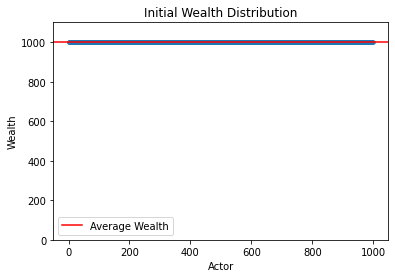

In [3]:
class GarageSale(Analysis):
    def __init__(self, N_exchanges=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if not N_exchanges:
            self.N_exchanges = self.N_actors
        else:
            self.N_exchanges = N_exchanges
        
    def run_round(self):
        """Run one round of the Garage Sale Model"""
        N = self.N_actors
        N_exchanges = self.N_exchanges
        ts = self.transaction_size
        bank = self.bank
        # Set up transaction information
        wealth_exchanged = np.zeros(N_exchanges)
        actor_exchanges = np.zeros(N_exchanges)
        partner_exchanges = np.zeros(N_exchanges)
        transactions = np.zeros(N)
        # Get actor/partner wealth
        actors = np.random.permutation(N)[:N_exchanges]
        partners = np.random.permutation(N)[:N_exchanges]
        actor_wealth = bank[actors]
        partner_wealth = bank[partners]
        # Determine amount of wealth exchanged
        actor_is_wealthier = (actor_wealth > partner_wealth)
        wealth_exchanged[actor_is_wealthier] = ts*partner_wealth[actor_is_wealthier]
        wealth_exchanged[~actor_is_wealthier] = ts*actor_wealth[~actor_is_wealthier]
        # Determine actor/partner exchanges
        actor_won_toss = (np.random.rand(N_exchanges) > 0.5)
        actor_exchanges = wealth_exchanged*(-1)**(~actor_won_toss)
        partner_exchanges = (-1)*actor_exchanges
        # Complete transactions
        transactions[actors] += actor_exchanges
        transactions[partners] += partner_exchanges
        
        return transactions
    
    def run(self):
        for e in tqdm(range(self.N_epochs)):
            transactions = self.run_round()
            self.update_bank(transactions, e)
            
affine0 = GarageSale()

In [4]:
affine0.run()

### 1.2 Plots

10.00% of actors have more wealth than average.


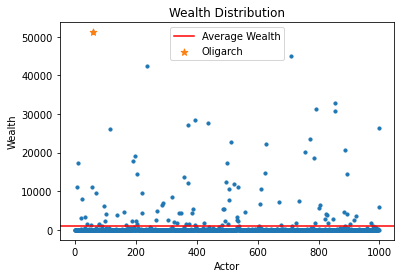

In [5]:
affine0.plot_wealth_dist(show_oligarch=True)

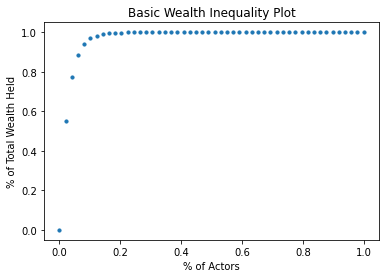

In [6]:
affine0.plot_wealth_ineq()

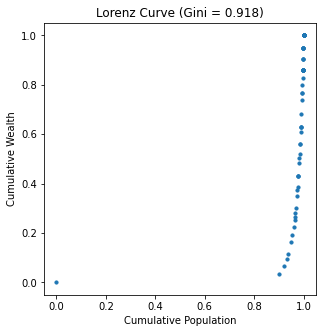

In [7]:
affine0.plot_lorenz_curve(N_points=1000)

## 2. To Each According to his Needs: $\chi$
We now introduce a common feature of modern economies: wealth redistribution. After each round of exchanges, we shift each actor's wealth by the following amount:

$$
W = \chi(\bar{w}-w)
$$

where $\bar{w}$ is the mean wealth of the entire population, $w$ is the individual's personal wealth, and $\chi\in[0,1]$. Thus, we notice that $W < 0$ if that particular actor holds more wealth than average and $W > 0$ otherwise. Overall, this results in all actors taking a step towards the mean wealth of the entire population.

### 2.1 Simulation

0.00% of actors have more wealth than average.


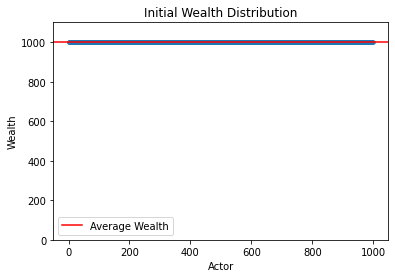

In [8]:
class WealthTax(GarageSale):
    def __init__(self, chi=0.0, *args, **kwargs):
        self.chi = chi
        super().__init__(*args, **kwargs)
        
    def redistribute(self, transactions):
        N_actors = self.N_actors
        bank = self.bank
        # Redistribute wealth
        actor_wealth = bank+transactions
        mean_wealth = np.ones(N_actors)*np.mean(actor_wealth)
        transactions += (mean_wealth-(actor_wealth))*self.chi

        return transactions
    
    def run(self):
        for e in tqdm(range(self.N_epochs)):
            transactions = self.run_round()
            redistributed = self.redistribute(transactions)
            self.update_bank(redistributed, e)
            
affine1 = WealthTax(chi=0.05, N_epochs=3000, transaction_size=0.1)

In [9]:
affine1.run()

### 2.2 Plots

45.30% of actors have more wealth than average.


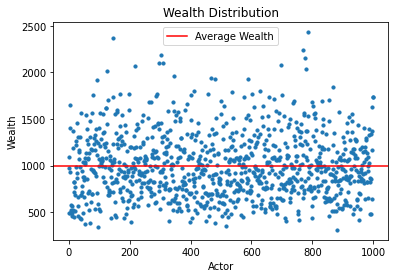

In [10]:
affine1.plot_wealth_dist()

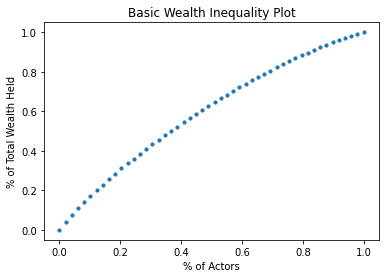

In [11]:
affine1.plot_wealth_ineq()

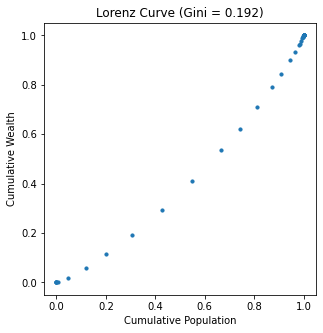

In [12]:
affine1.plot_lorenz_curve(N_points=10000)

## 3. The Rich Get Richer: $\zeta$
So far, the exchange in the Garage Sale Model has been agnostically governed by the flip of a pseudo-fair coin. Now, in an attempt to model the real bias of everyday exchanges, we allow the coin flip to be biased towards the wealthier actor. To do this, we must modify the coin flip such that our outcome $\mathcal{R}$ has an expectation value given by

$$
\langle\mathcal{R}\rangle = \zeta\bigg(\frac{w-w'}{\bar{w}}\bigg)
$$

where $\bar{w}$ is again the mean wealth of the entire population, $w$ is the wealth of the actor, $w'$ is the wealth of their partner, and $\zeta\in[0,1]$. We notice that if $w > w'$, if the actor is wealthier than their partner, then $\langle\mathcal{R}\rangle > 0$ which implies that the actor will _win_ the coin toss on average. Conversely, if the actor is poorer than their parter ($w < w'$), then $\langle\mathcal{R}\rangle < 0$ so the actor will _lose_ the coin toss on average. Refer back to Section 1 for how the coin toss determines the outcome of the transaction in our garage sale model.

By the definition of $\langle\mathcal{R}\rangle$, then, we may simply find $p(\mathcal{R}=+1)$ and $p(\mathcal{R}=-1)$:

$$
\begin{align}
\langle\mathcal{R}\rangle &\equiv (1)p(\mathcal{R}=+1) + (-1)p(\mathcal{R}=-1)
\\
\zeta\bigg(\frac{w-w'}{\bar{w}}\bigg) &= p(\mathcal{R}=+1) - p(\mathcal{R}=-1)
\end{align}
$$

However, we have the fundamental constraint that $p(\mathcal{R}=+1) + p(\mathcal{R}=-1) = 1$. Adding this equation to the above, we obtain

$$
\begin{align}
\zeta\frac{w}{\bar{w}}-\zeta\frac{w'}{\bar{w}}+1 &= 2p(\mathcal{R}=+1)
\\
p(\mathcal{R}=+1) &= \frac{\zeta}{2}\bigg(\frac{w}{\bar{w}}-\frac{w'}{\bar{w}}\bigg)+\frac{1}{2}
\\
\implies p(\mathcal{R}=-1) &= \frac{1}{2}-\frac{\zeta}{2}\bigg(\frac{w}{\bar{w}}-\frac{w'}{\bar{w}}\bigg)
\end{align}
$$

We can now use either of the above as a working point for biasing the coin toss. At the same time, we see that this leaves $\langle\mathcal{R}^2\rangle$ unchanged, that is $\langle\mathcal{R}^2\rangle = 1$ since we still have $\mathcal{R}\in\{-1,1\}$. From these, of course, we may calculate the standard deviation $\sigma = \sqrt{\langle\mathcal{R}^2\rangle-\langle\mathcal{R}\rangle^2}$. Explicitly, we have

$$
\sigma = \sqrt{1-\zeta^2\bigg(\frac{w-w'}{\bar{w}}\bigg)^2}
$$

The mean $\mu \equiv \langle\mathcal{R}\rangle$ and standard deviation $\sigma$ define a Gaussian distribution which we could sample for our biased coin toss.

Alternatively, and perhaps more accurately, we could define a binomial distribution:

$$
\begin{align}
\mu &= np\\
\sigma^2 &= np(1-p)\\
\implies p &= 1-\frac{\sigma^2}{\mu}, n=\frac{\mu}{1-\frac{\sigma^2}{\mu}}
\end{align}
$$

However, we must be careful of how we would define $\mu$ and $\sigma$, since we are counting _successes_ after $n$ tosses with a binomial distribution, whereas here we simply care about the outcome of a single coin toss per transaction.

### 3.1 Simulation

0.00% of actors have more wealth than average.


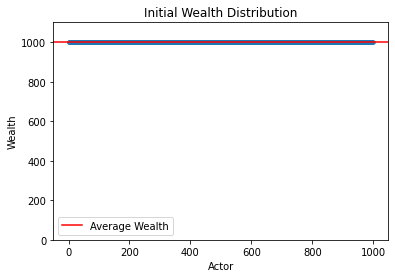

In [13]:
class BiasedGarageSale(WealthTax):
    def __init__(self, chi=0.0, zeta=0.0, *args, **kwargs):
        self.zeta = zeta
        super().__init__(chi=chi, *args, **kwargs)
        
    def run_round(self):
        """Run one round of the Garage Sale Model biased towards the
           wealthier party
        """
        N = self.N_actors
        N_exchanges = self.N_exchanges
        ts = self.transaction_size
        bank = self.bank
        total_wealth = np.sum(bank)
        # Set up transaction information
        wealth_exchanged = np.zeros(N_exchanges)
        actor_exchanges = np.zeros(N_exchanges)
        partner_exchanges = np.zeros(N_exchanges)
        transactions = np.zeros(N)
        # Get actor/partner wealth
        actors = np.random.permutation(N)[:N_exchanges]
        partners = np.random.permutation(N)[:N_exchanges]
        actor_wealth = bank[actors]
        partner_wealth = bank[partners]
        # Determine amount of wealth exchanged
        actor_is_wealthier = (actor_wealth > partner_wealth)
        wealth_exchanged[actor_is_wealthier] = ts*partner_wealth[actor_is_wealthier]
        wealth_exchanged[~actor_is_wealthier] = ts*actor_wealth[~actor_is_wealthier]
        # Determine actor/partner exchanges
        prob_minus1 = 0.5*(1-self.zeta*(actor_wealth-partner_wealth)/(total_wealth/N))
        actor_won_toss = (np.random.rand(N_exchanges) > (prob_minus1))
        actor_exchanges = wealth_exchanged*(-1)**(~actor_won_toss)
        partner_exchanges = (-1)*actor_exchanges
        # Complete transactions
        transactions[actors] += actor_exchanges
        transactions[partners] += partner_exchanges
        
        return transactions

affine2 = BiasedGarageSale(chi=0.036, zeta=0.05)

In [14]:
affine2.run()

### 3.2 Plots

40.90% of actors have more wealth than average.


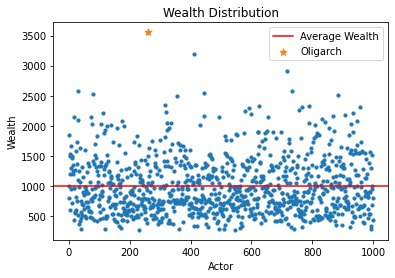

In [15]:
affine2.plot_wealth_dist(show_oligarch=True)

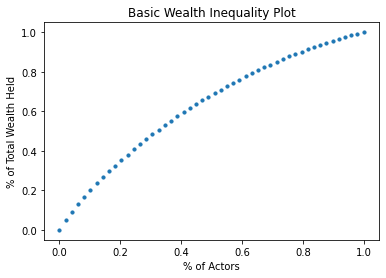

In [16]:
affine2.plot_wealth_ineq()

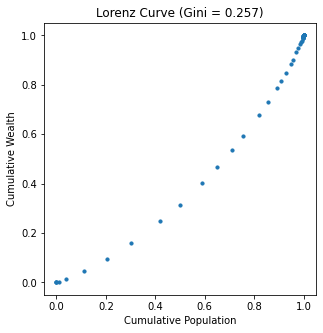

In [17]:
affine2.plot_lorenz_curve(N_points=10000)

## 4. Negative Wealth: $\kappa$
For all of the plots produced above, no actor can have wealth less than zero. This is because the actor can only lose some percentage of their personal wealth after any exchange, meaning they can actually only _approach_ zero in theory. This is not, of course, realistic. It is a simple fact that many people are in debt, so the poorest should actually have _negative_ wealth. To address this, we require that an actor can have wealth no less than $-\Lambda$ at any time, which is defined as follows (from here[3], Eq. (24) taking $\Delta \rightarrow \Lambda$ for personal preference):

$$
\Lambda = \bigg(\frac{\kappa}{1-\kappa}\bigg)\bar{w}
$$

where $\kappa\in[0,1]$. Then, before each transaction, we loan every actor $\Lambda$ and require that they pay back their debt after the transaction, effectively shifting the wealth distribution to allow for negative wealth.

### 4.1 Simulation

0.00% of actors have more wealth than average.


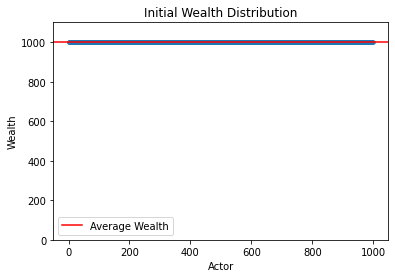

In [18]:
class LoanShark(BiasedGarageSale):
    def __init__(self, chi=0.0, zeta=0.0, kappa=0.0, *args, **kwargs):
        self.kappa = kappa
        super().__init__(chi=chi, zeta=zeta, *args, **kwargs)
        
    def run(self):
        for e in tqdm(range(self.N_epochs)):
            bank = self.bank
            kappa = self.kappa
            # Apply loans
            loans = np.ones(self.N_actors)*(kappa/(1-kappa))*np.mean(bank)
            self.bank += loans
            # Run transactions
            transactions = self.run_round()
            redistributed = self.redistribute(transactions)
            # Update bank with remainder after loan collection
            self.update_bank(redistributed-loans, e)

affine3 = LoanShark(N_epochs=5000, chi=0.05, kappa=0.1, zeta=0.05)

In [19]:
affine3.run()

### 4.2 Plots

43.90% of actors have more wealth than average.


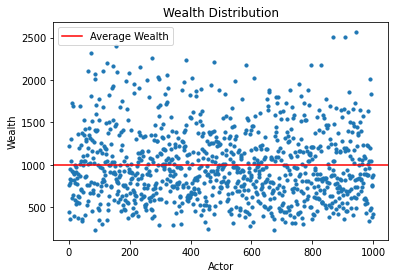

In [20]:
affine3.plot_wealth_dist()

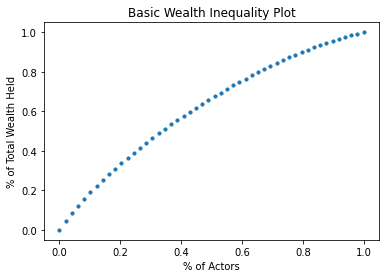

In [21]:
affine3.plot_wealth_ineq()

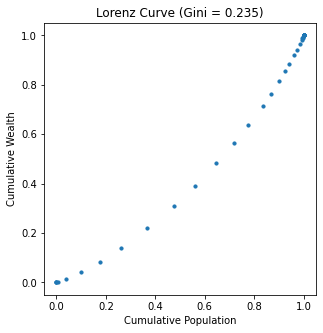

In [22]:
affine3.plot_lorenz_curve(N_points=10000)

## 5. Consolidating the Affine Model
So far, the different models have been iteratively built upon by a somewhat convoluted chain of inheritance. For convenience, we will consolidate this into a single class.

In [23]:
class Affine(Analysis):
    def __init__(self, chi=0.0, zeta=0.0, kappa=0.0, N_exchanges=None,
                 *args, **kwargs):
        self.chi = chi
        self.zeta = zeta
        self.kappa = kappa
        super().__init__(*args, **kwargs)
        if not N_exchanges:
            self.N_exchanges = self.N_actors
        else:
            self.N_exchanges = N_exchanges
        
    def run_round(self):
        """Run one round of the Garage Sale Model biased towards the
           wealthier party
        """
        N = self.N_actors
        N_exchanges = self.N_exchanges
        ts = self.transaction_size
        bank = self.bank
        total_wealth = np.sum(bank)
        # Set up transaction information
        wealth_exchanged = np.zeros(N_exchanges)
        actor_exchanges = np.zeros(N_exchanges)
        partner_exchanges = np.zeros(N_exchanges)
        transactions = np.zeros(N)
        # Get actor/partner wealth
        actors = np.random.permutation(N)[:N_exchanges]
        partners = np.random.permutation(N)[:N_exchanges]
        actor_wealth = bank[actors]
        partner_wealth = bank[partners]
        # Determine amount of wealth exchanged
        actor_is_wealthier = (actor_wealth > partner_wealth)
        wealth_exchanged[actor_is_wealthier] = ts*partner_wealth[actor_is_wealthier]
        wealth_exchanged[~actor_is_wealthier] = ts*actor_wealth[~actor_is_wealthier]
        # Determine actor/partner exchanges
        prob_minus1 = 0.5*(1-self.zeta*(actor_wealth-partner_wealth)/(total_wealth/N))
        actor_won_toss = (np.random.rand(N_exchanges) > (prob_minus1))
        actor_exchanges = wealth_exchanged*(-1)**(~actor_won_toss)
        partner_exchanges = (-1)*actor_exchanges
        # Complete transactions
        transactions[actors] += actor_exchanges
        transactions[partners] += partner_exchanges
        
        return transactions
        
    def redistribute(self, transactions):
        """Apply wealth tax after running base model"""
        N_actors = self.N_actors
        bank = self.bank
        # Redistribute wealth
        actor_wealth = bank+transactions
        mean_wealth = np.ones(N_actors)*np.mean(actor_wealth)
        transactions += (mean_wealth-(actor_wealth))*self.chi

        return transactions
    
    def run(self):
        """Run simulation"""
        for e in tqdm(range(self.N_epochs)):
            bank = self.bank
            kappa = self.kappa
            # Apply loans
            loans = np.ones(self.N_actors)*(kappa/(1-kappa))*np.mean(bank)
            self.bank += loans
            # Run transactions
            transactions = self.run_round()
            redistributed = self.redistribute(transactions)
            # Update bank with remainder after loan collection
            self.update_bank(redistributed-loans, e)

## 6. Simulating Real-world Economies

### 6.1 The United States
According to the article, the 2016 U.S. household wealth distribution is best described as having  $\chi = 0.036$, $\zeta = 0.050$ and $\kappa = 0.058$.

#### 6.1.1 Simulation

0.00% of actors have more wealth than average.


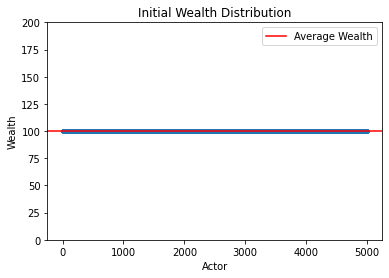

In [24]:
united_states = Affine(
    N_epochs=2000, 
    N_checkpoints=200, 
    transaction_size=0.25, 
    starting_wealth=100,                     
    N_actors=5000, 
    chi=0.036, 
    kappa=0.058, 
    zeta=0.05
)

In [25]:
united_states.run()

#### 6.1.2 Plots

31.56% of actors have more wealth than average.


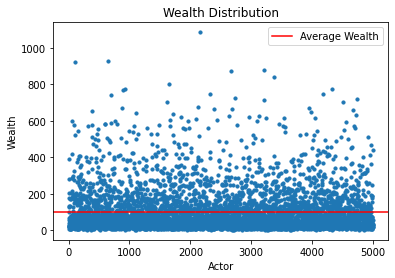

In [26]:
united_states.plot_wealth_dist()

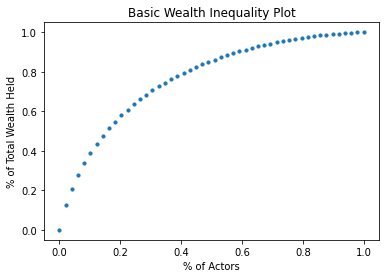

In [27]:
united_states.plot_wealth_ineq()

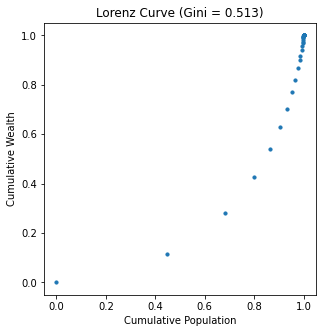

In [28]:
united_states.plot_lorenz_curve(N_points=10000)

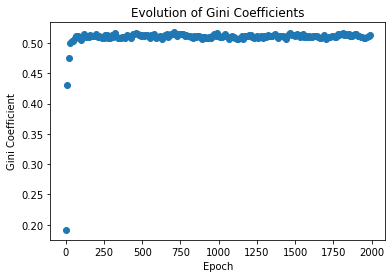

In [29]:
united_states.plot_gini_evolution()

## Bibliography
1. https://www.scientificamerican.com/article/is-inequality-inevitable/
2. https://arxiv.org/abs/1511.00770
3. https://arxiv.org/abs/1604.02370
4. https://arxiv.org/abs/1212.6300.pdf
5. https://en.wikipedia.org/wiki/Gini_coefficient
6. https://en.wikipedia.org/wiki/List_of_countries_by_wealth_equality